In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')


from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerThreeClass, all_subjects, all_subjects_intense

import numpy as np
from tqdm import tqdm
import csv
import torch

### Siamese training

In [2]:
subjects_test = all_subjects[:1]
subjects_train = [sub for sub in all_subjects if sub not in subjects_test]

set hyperparameters for models and trainer

In [9]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects.pkl",
    "subjects_train": all_subjects,
    "subjects_test": subjects_test,
    "intense_dataset_train": False,
    "intense_dataset_test": False,
    "xite_2class_train": True,
    "xite_2class_test": True,
    "indices1_train": 4,
    "indices2_train": 1,
    "indices1_test": 1,
    "indices2_test": 0,
    "use_regression": False,
    "wandb": False,
    "log": True,
    "learning_rate": 0.001,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "decision_function": 3,
    "filter": [1,2,3],
    "weight_decay": 0,
    "lr_steps": 10,
    "number_steps": 200,
    "number_steps_testing": 5
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

if trainer_hyperparameter["use_regression"]:
    head = 1
else:
    head = 2

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [64, 32],
    "head_type": head
}


#
# head 1 for regression
# head 2 for classification
#

generate siamese models with the corresponding classification network and embedding network

In [10]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])
#_ = siamese_model.load_state_dict(torch.load("D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\pretrained_models\model_all_2class.pth"))

generate filter for xite (heat, electric...) and generate trainer class

In [11]:
filter = lambda data: data["label"].isin(trainer_hyperparameter["filter"])
trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0", filter=filter)

train the network

In [12]:
trainer.trainloop(20)

100%|██████████| 20/20 [1:44:24<00:00, 313.23s/it]

epoch: 1 | train_acc: 0.6137 | test_acc: 0.7167
epoch: 2 | train_acc: 0.6585 | test_acc: 0.8
epoch: 3 | train_acc: 0.6746 | test_acc: 0.7778
epoch: 4 | train_acc: 0.6852 | test_acc: 0.8167
epoch: 5 | train_acc: 0.6881 | test_acc: 0.7778
epoch: 6 | train_acc: 0.6984 | test_acc: 0.8222
epoch: 7 | train_acc: 0.7029 | test_acc: 0.8333
epoch: 8 | train_acc: 0.705 | test_acc: 0.8056
epoch: 9 | train_acc: 0.709 | test_acc: 0.8722
epoch: 10 | train_acc: 0.7097 | test_acc: 0.8778
epoch: 11 | train_acc: 0.7174 | test_acc: 0.8556
epoch: 12 | train_acc: 0.7233 | test_acc: 0.8556
epoch: 13 | train_acc: 0.7275 | test_acc: 0.8778
epoch: 14 | train_acc: 0.7323 | test_acc: 0.8833
epoch: 15 | train_acc: 0.7285 | test_acc: 0.8889
epoch: 16 | train_acc: 0.7336 | test_acc: 0.8667
epoch: 17 | train_acc: 0.7346 | test_acc: 0.9056
epoch: 18 | train_acc: 0.736 | test_acc: 0.8944
epoch: 19 | train_acc: 0.7366 | test_acc: 0.9167
epoch: 20 | train_acc: 0.7418 | test_acc: 0.9111


save model if needed

In [13]:
torch.save(siamese_model.state_dict(), "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\pretrained_models\model_phasic_heat_2class.pth")

display results

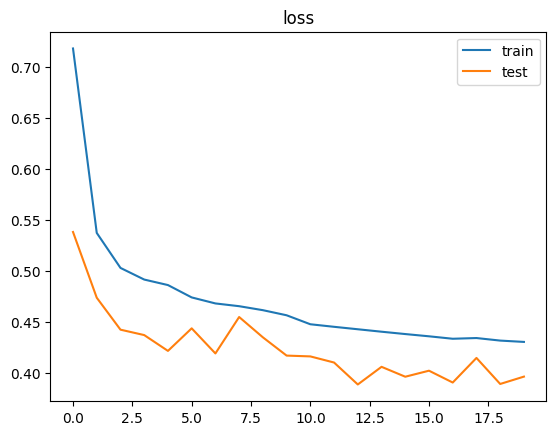

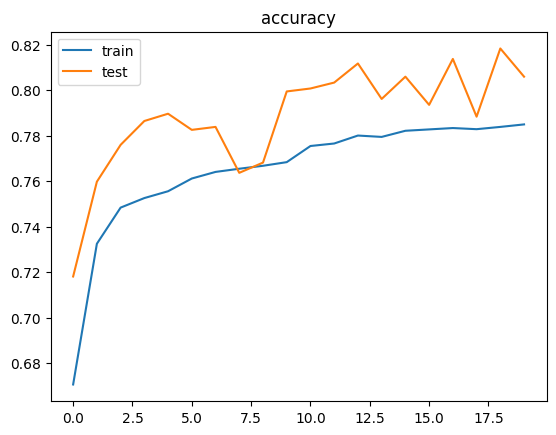

In [21]:
trainer.plot_history()

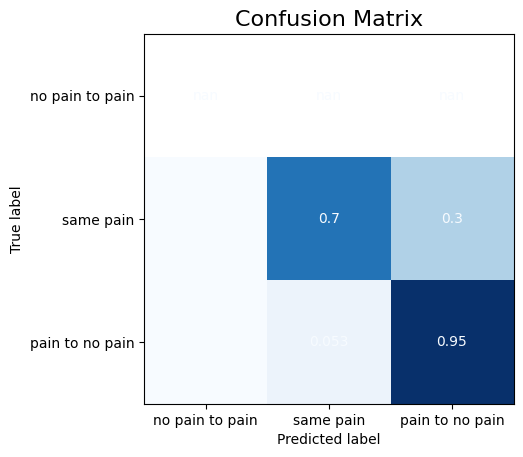

In [22]:
trainer.plot_cm()

### saving file

In [4]:
saving_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\\results\\pretrained_2class\\pretraining_xite_tonic_electric_2class_intense_4_0_1_0.csv"
model_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\ThreeClassSiamese\pretrained_models\model_tonic_electric_2class.pth"

with open(saving_path, mode='a') as result_file:
    results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    results_writer.writerow(["subj", "accuracy", "cm", "best_epoch"])

### LOSO - INTENSE

use LOSO cross validation on INTENSE dataset

In [5]:
for subj in tqdm(all_subjects_intense):
    subjects_test = [subj]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE2\\normalized_subjects.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "intense_dataset_train": True,
        "intense_dataset_test": True,
        "xite_2class_train": False,
        "xite_2class_test": False,
        "indices1_train": 4,
        "indices2_train": 0,
        "indices1_test": 1,
        "indices2_test": 0,
        "use_regression": False,
        "wandb": False,
        "log": True,
        "learning_rate": 0.001,
        "batch_size": 256,
        "batch_size_test": 256,
        "freeze_embed": False,
        "decision_function": 3,
        "filter": [],
        "weight_decay": 0,
        "lr_steps": 10,
        "number_steps": 400,
        "number_steps_testing": 200
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    if trainer_hyperparameter["use_regression"]:
        head = 1
    else:
        head=2

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [64, 32],
        "head_type": head
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)
    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])
    
    _ = siamese_model.load_state_dict(torch.load(model_path))
    
    trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(30)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]

    acc = trainer.history[best_epoch-1]["test_acc"]

    s = np.sum(cm, axis=1)
    cm = cm.astype('float64')
    cm[0] = cm[0]/s[0]
    cm[1] = cm[1]/s[1]
    cm[2] = cm[2]/s[2]

    with open(saving_path, mode='a') as result_file:
        results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        results_writer.writerow([subj, acc*100, cm, best_epoch])

100%|██████████| 24/24 [57:41<00:00, 144.24s/it]

epoch: 1 | train_acc: 0.6824 | test_acc: 0.7059
epoch: 2 | train_acc: 0.8185 | test_acc: 0.8529
epoch: 3 | train_acc: 0.872 | test_acc: 0.8529
epoch: 4 | train_acc: 0.8878 | test_acc: 0.8824
epoch: 5 | train_acc: 0.9101 | test_acc: 0.8529
epoch: 6 | train_acc: 0.9204 | test_acc: 0.8824
epoch: 7 | train_acc: 0.9332 | test_acc: 0.8824
epoch: 8 | train_acc: 0.9426 | test_acc: 0.8824
epoch: 9 | train_acc: 0.9478 | test_acc: 0.8824
epoch: 10 | train_acc: 0.9555 | test_acc: 0.9118
epoch: 11 | train_acc: 0.9632 | test_acc: 0.9118
epoch: 12 | train_acc: 0.9666 | test_acc: 0.8824
epoch: 13 | train_acc: 0.9717 | test_acc: 0.9118
epoch: 14 | train_acc: 0.9777 | test_acc: 0.9412
epoch: 15 | train_acc: 0.9735 | test_acc: 0.9412
epoch: 16 | train_acc: 0.9756 | test_acc: 0.9412
epoch: 17 | train_acc: 0.9782 | test_acc: 0.9412
epoch: 18 | train_acc: 0.9786 | test_acc: 0.9118
epoch: 19 | train_acc: 0.9842 | test_acc: 0.9412
epoch: 20 | train_acc: 0.9867 | test_acc: 0.9118
epoch: 21 | train_acc: 0.9863 

### 10 - Fold - XITE

use 10 fold cross validation for xite dataset ( no loop for using multiple scipts at the same time => speed up time)

In [3]:
x=6
subjects_test = all_subjects[x*13:(x+1)*13]
subjects_train = [sub for sub in all_subjects if sub not in subjects_test]

trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "intense_dataset_train": False,
    "intense_dataset_test": False,
    "indices1_train": 3,
    "indices2_train": 1,
    "indices1_test": 1,
    "indices2_test": 0,
    "use_regression": False,
    "wandb": False,
    "log": True,
    "learning_rate": 0.001,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "decision_function": 3,
    "filter": [4,5,6],
    "weight_decay": 0,
    "lr_steps": 10,
    "number_steps": 200,
    "number_steps_testing": 100
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

if trainer_hyperparameter["use_regression"]:
    head = 1
else:
    head=2

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [64, 32],
    "head_type": head
}

classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)
siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

trainer = SiameseTrainerThreeClass(trainer_hyperparameter, siamese_model, device="cuda:0")

In [4]:
trainer.trainloop(30)

100%|██████████| 30/30 [1:22:53<00:00, 165.79s/it]

epoch: 1 | train_acc: 0.5557 | test_acc: 0.5941
epoch: 2 | train_acc: 0.6036 | test_acc: 0.5928
epoch: 3 | train_acc: 0.61 | test_acc: 0.6057
epoch: 4 | train_acc: 0.6209 | test_acc: 0.622
epoch: 5 | train_acc: 0.6246 | test_acc: 0.6055
epoch: 6 | train_acc: 0.6283 | test_acc: 0.5939
epoch: 7 | train_acc: 0.6384 | test_acc: 0.6112
epoch: 8 | train_acc: 0.6404 | test_acc: 0.6086
epoch: 9 | train_acc: 0.6418 | test_acc: 0.61
epoch: 10 | train_acc: 0.6465 | test_acc: 0.6077
epoch: 11 | train_acc: 0.6473 | test_acc: 0.5995
epoch: 12 | train_acc: 0.656 | test_acc: 0.6185
epoch: 13 | train_acc: 0.6509 | test_acc: 0.6166
epoch: 14 | train_acc: 0.657 | test_acc: 0.6195
epoch: 15 | train_acc: 0.6581 | test_acc: 0.6214
epoch: 16 | train_acc: 0.6545 | test_acc: 0.6263
epoch: 17 | train_acc: 0.6613 | test_acc: 0.6125
epoch: 18 | train_acc: 0.6604 | test_acc: 0.6311
epoch: 19 | train_acc: 0.6602 | test_acc: 0.6191
epoch: 20 | train_acc: 0.6643 | test_acc: 0.611
epoch: 21 | train_acc: 0.6651 | test_

calculate results for saving

In [5]:
best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
cm = trainer.history_cm[best_epoch-1]["cm"]

acc = trainer.history[best_epoch-1]["test_acc"]

s = np.sum(cm, axis=1)
cm = cm.astype('float64')
cm[0] = cm[0]/s[0]
cm[1] = cm[1]/s[1]
cm[2] = cm[2]/s[2]

In [6]:
acc

0.6311

save results into file

In [7]:
with open(saving_path, mode='a') as result_file:
    results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    results_writer.writerow(["split_"+str(x), acc*100, cm, best_epoch])